# 1. Install Dependencies and Setup

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

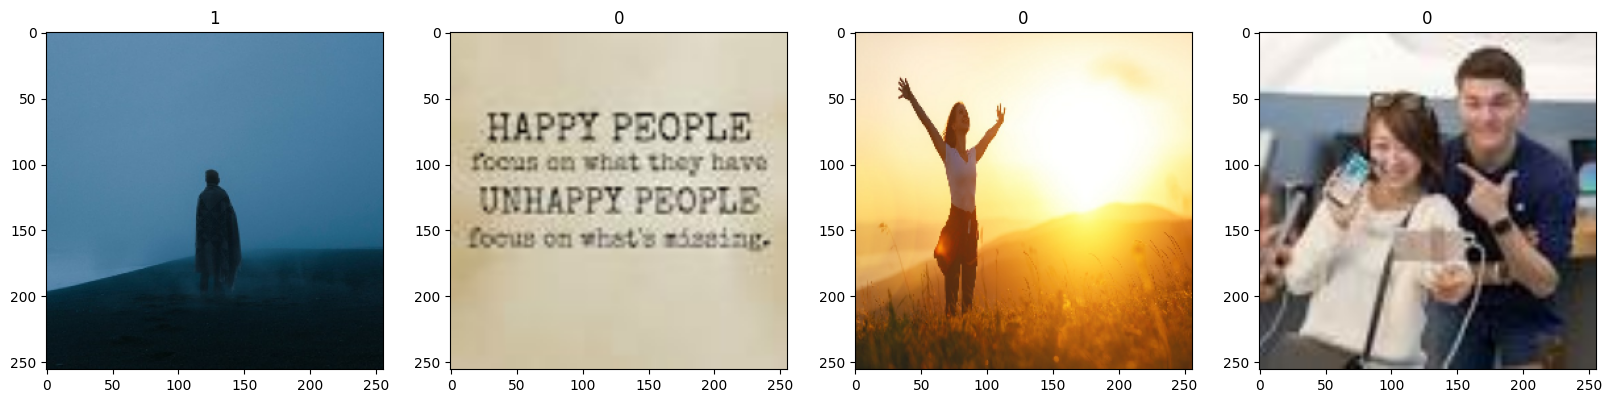

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [13]:
data = data.map(lambda x,y: (x/255, y))

In [14]:
data.as_numpy_iterator().next()

(array([[[[0.4912071 , 0.51473653, 0.46835172],
          [0.50701594, 0.53054535, 0.49132967],
          [0.5299939 , 0.5568934 , 0.51599264],
          ...,
          [0.797212  , 0.85211396, 0.85211396],
          [0.7805147 , 0.8354167 , 0.8354167 ],
          [0.7657169 , 0.82061887, 0.82061887]],
 
         [[0.4912071 , 0.51473653, 0.46835172],
          [0.50701594, 0.53054535, 0.49132967],
          [0.5299939 , 0.5568934 , 0.51599264],
          ...,
          [0.79834414, 0.8532461 , 0.8532461 ],
          [0.7805147 , 0.8354167 , 0.8354167 ],
          [0.7681253 , 0.82302725, 0.82302725]],
 
         [[0.4912071 , 0.51473653, 0.46835172],
          [0.50701594, 0.53054535, 0.49132967],
          [0.5299939 , 0.5568934 , 0.51599264],
          ...,
          [0.7988971 , 0.85379905, 0.85379905],
          [0.7805147 , 0.8354167 , 0.8354167 ],
          [0.7693015 , 0.82420343, 0.82420343]],
 
         ...,
 
         [[0.358824  , 0.36274558, 0.33921617],
          [0.36179

# 5. Split Data

In [15]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [16]:
train_size

7

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [18]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [20]:
model = Sequential()

In [21]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [24]:
logdir='logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 29s 2s/step - loss: 1.1500 - accuracy: 0.4732 - val_loss: 0.6584 - val_accuracy: 0.5312
Epoch 2/20
7/7 [==============================] - 14s 1s/step - loss: 0.6524 - accuracy: 0.5268 - val_loss: 0.6145 - val_accuracy: 0.5312
Epoch 3/20
7/7 [==============================] - 14s 1s/step - loss: 0.6139 - accuracy: 0.6250 - val_loss: 0.6750 - val_accuracy: 0.5625
Epoch 4/20
7/7 [==============================] - 15s 2s/step - loss: 0.5491 - accuracy: 0.7009 - val_loss: 0.6849 - val_accuracy: 0.6406
Epoch 5/20
7/7 [==============================] - 25s 3s/step - loss: 0.4729 - accuracy: 0.8214 - val_loss: 0.4946 - val_accuracy: 0.8281
Epoch 6/20
7/7 [==============================] - 17s 1s/step - loss: 0.3753 - accuracy: 0.8527 - val_loss: 0.3149 - val_accuracy: 0.8906
Epoch 7/20
7/7 [==============================] - 13s 1s/step - loss: 0.3119 - accuracy: 0.9152 - val_loss: 0.2543 - val_accuracy: 0.8906
Epoch 8/20
7/7 [==================

# 8. Plot Performance

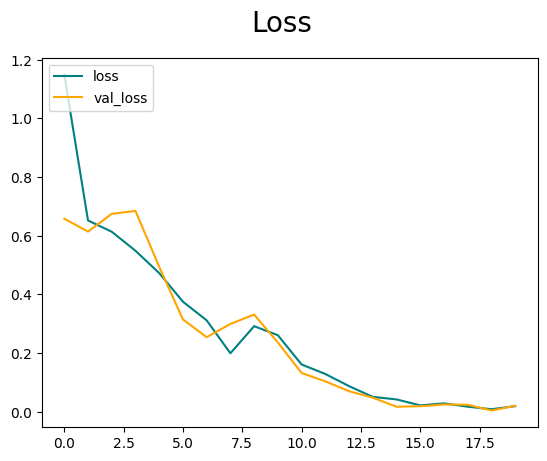

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

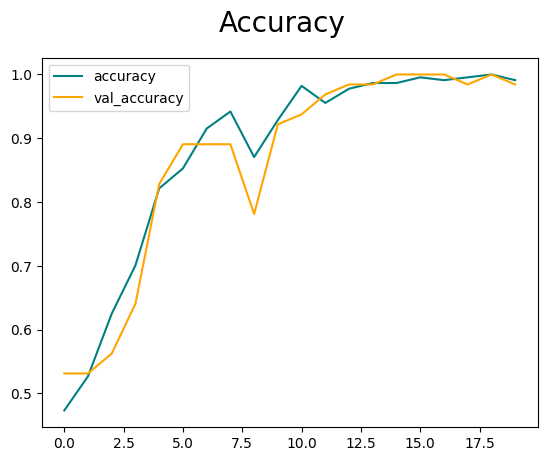

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [32]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [33]:
import cv2

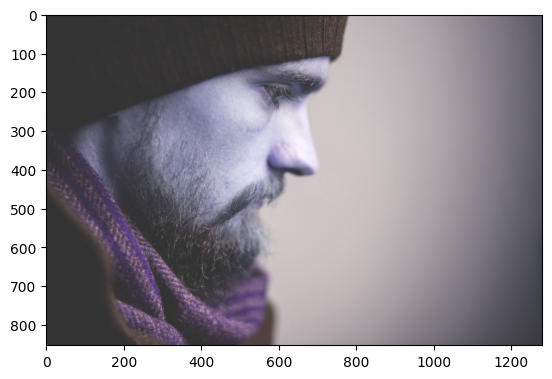

In [34]:
img = cv2.imread('sad.jpg')
plt.imshow(img)
plt.show()

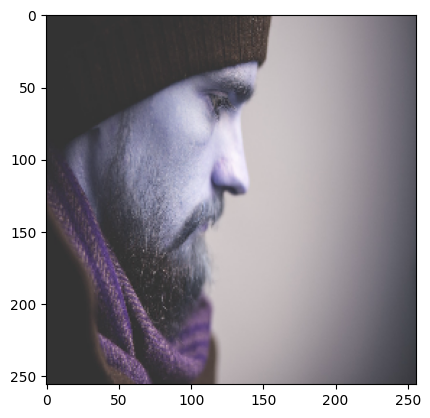

In [35]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [36]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [37]:
yhat

array([[0.9863036]], dtype=float32)

In [38]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [39]:
from tensorflow.keras.models import load_model

In [40]:
model.save(os.path.join('models','imageclassifier.h5'))

In [41]:
new_model = load_model(os.path.join('models', 'imageclassifier.h5'))

#fix it

In [42]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.9863036]], dtype=float32)